In [1]:
# Python libraries
import sys
import numpy as np
from scipy import interpolate

# Just for plotting, not needed for flux calculations
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import Normalize
mpl.rcParams['figure.dpi']= 150



In [2]:
# Mode of use
# 1. Pick a set of parameters. If you let them at zero, you get our best fit point.
# 2. Make tables that you can use to assign weights to the MC
# 3. A given set of tables comes from one set of parameters, you can evaluate the chi2 from the tables
# The table-making would have to be redone at every step of a minimization process

# Examples of standalone and table-making snippets below

In [3]:
# Calibrated flux modules
from phantomflux import Flux
# import phantom_flux_public
# reload(phantom_flux_public)

In [18]:
# Test for a single zenith angle
phantom_flux = Flux()
exp = 'IceCube'
icangles = list(phantom_flux.fl_spl[exp].keys())
icangles[0]
egrid = np.logspace(-1,5.99),
particle='numuflux'
index=0
phantom_flux.get_flux_new(egrid, exp, icangles[index], particle,
                       params={'le_pi+':1})

Excluded params removed from known_params.
Adjusting DEIS name


array([[0.00527025, 0.00878968, 0.01300953, 0.01725155, 0.02247566,
        0.02903785, 0.03378638, 0.03671239, 0.03901869, 0.04064719,
        0.04179599, 0.04153266, 0.041917  , 0.04208295, 0.04199386,
        0.04166911, 0.04106539, 0.04021271, 0.03911199, 0.03764219,
        0.03578399, 0.03411802, 0.03265299, 0.03114213, 0.02951209,
        0.0277019 , 0.02564237, 0.02336353, 0.02083079, 0.01823201,
        0.01562689, 0.0131626 , 0.01093694, 0.00899912, 0.00736941,
        0.00601593, 0.00490368, 0.00399023, 0.00323946, 0.00262068,
        0.00210845, 0.0016841 , 0.00132753, 0.00103207, 0.00078799,
        0.0005897 , 0.00043138, 0.00030678, 0.0002126 , 0.00014315]])

In [19]:
# These are the valid parameters to modify
# Pass them in a dictionary with values in units of sigma (single parameter)
# When you evaluate the flux 
phantom_flux.known_params

['he_K+',
 'he_K-',
 'he_n',
 'he_p',
 'he_pi+',
 'he_pi-',
 'le_K+',
 'le_K-',
 'le_pi+',
 'le_pi-',
 'vhe1_pi+',
 'vhe1_pi-',
 'vhe3_K+',
 'vhe3_K-',
 'vhe3_n',
 'vhe3_p',
 'vhe3_pi+',
 'vhe3_pi-',
 'GSF_1',
 'GSF_2',
 'GSF_3',
 'GSF_4',
 'GSF_5',
 'GSF_6']

In [20]:
# After a flux was evaluated, the chi2 is computed using the covariance matrix
# To get it, simply call
phantom_flux.chi2_value

4.130182434509457

In [21]:
# Making a 2D flux map (E vs zenith) for a particle flux
def make2Dmap(particle = 'numuflux',
              egrid = np.logspace(-1,5.99),
              params = {},
              mag = 0.,
              plot=True,
              flux = None
             ):

    exp = 'IceCube'
    
    # Reference
    flux = flux if flux else Flux()

    icangles = list(flux.fl_spl[exp].keys())
    
    # Sorting the angles in the dictionary
    icangles_array = np.array(icangles, dtype=float)
    mysort = icangles_array.argsort()
    icangles = np.array(icangles)[mysort][::-1]
    
    flux_ref = np.zeros([len(egrid), len(icangles)])
    flux_test = np.zeros([len(egrid), len(icangles)])

    costheta_angles = np.zeros(len(icangles))
 
    for index in range(len(icangles)):
        costheta = np.cos(np.deg2rad(np.float64(icangles[index])))
        costheta_angles[index] = costheta
        flux_ref[:,index] = flux.get_flux_new(egrid, exp, icangles[index], particle,
                                                   params)                   
    
    # Save "fcn" and evaluate it to get the flux as function of E and zenith for this particle
    fcn = interpolate.RectBivariateSpline(np.log10(egrid), 
                                          costheta_angles,
                                          flux_ref)  
    

    return fcn, flux_ref, egrid, costheta_angles

### CALIBRATED FLUX

In [22]:
fcn, flux, egrid, ctheta = make2Dmap(particle='numu', mag=3., flux=phantom_flux)

In [23]:
# Evaluating the function "fcn" which has the NuMu flux
myegrid = np.log10(egrid)
myctheta = np.linspace(-1,1, 71)
mypoints = np.zeros([len(myegrid), len(myctheta)])
for ie in range(myegrid.size):
    for it in range(myctheta.size):
        mypoints = fcn(myegrid, myctheta)

Text(0, 0.5, '$\\cos{\\theta}$')

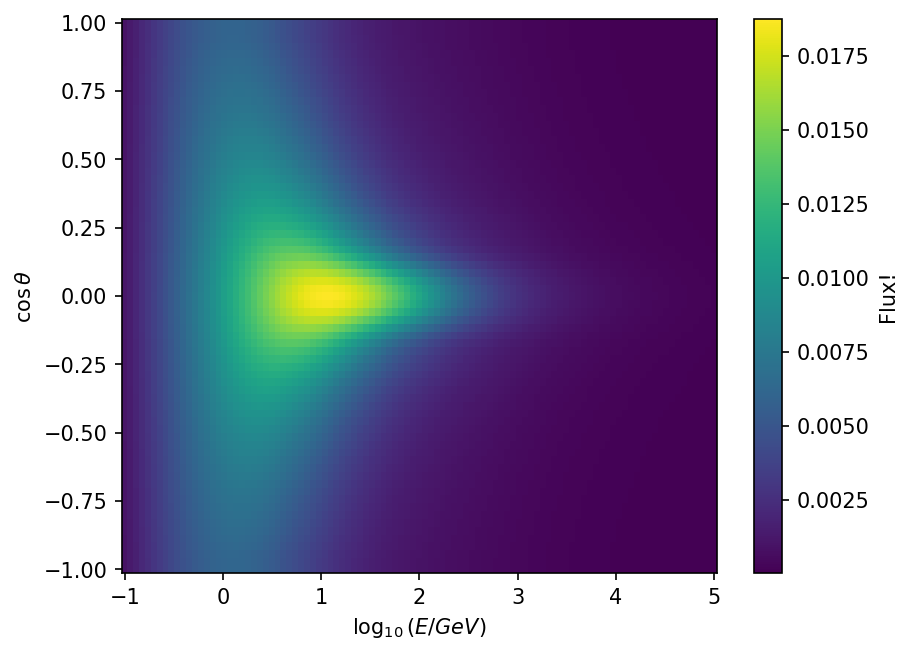

In [35]:
# Plotting it
plt.pcolor(myegrid, myctheta, mypoints.T)
plt.colorbar(label='Flux!')
plt.xlabel(r'$\log_{10}(E/GeV)$')
plt.ylabel(r'$\cos{\theta}$')

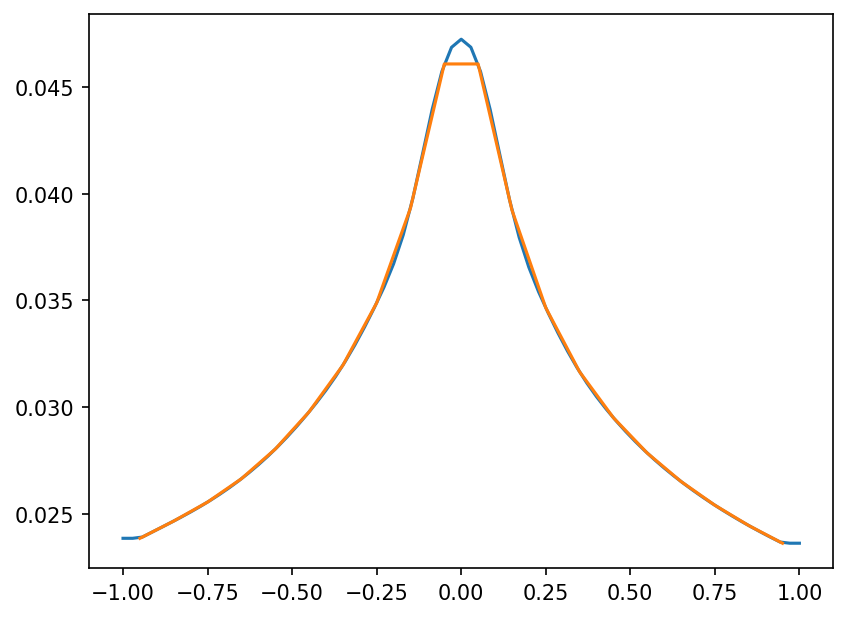

In [25]:
# Taking a slice to check zenith angle flux
ref = 17
thise = 10**myegrid[ref]
plt.plot(myctheta, mypoints[ref,:])
plt.plot(ctheta, flux[ref,:])


In [26]:
# Look to obtain all the flux functions for a given calibration
fluxes = {}
particles = ["numu", "antinumu", "nue", "antinue"]
for p in particles:
    fluxes[p] = {"spl3": None, "flux": None, "egrid": None, "ctheta": None}
    (
        fluxes[p]["spl3"],
        fluxes[p]["flux"],
        fluxes[p]["egrid"],
        fluxes[p]["ctheta"],
    ) = make2Dmap(particle=onep, mag=3.0, plot=False, flux=phantom_flux)


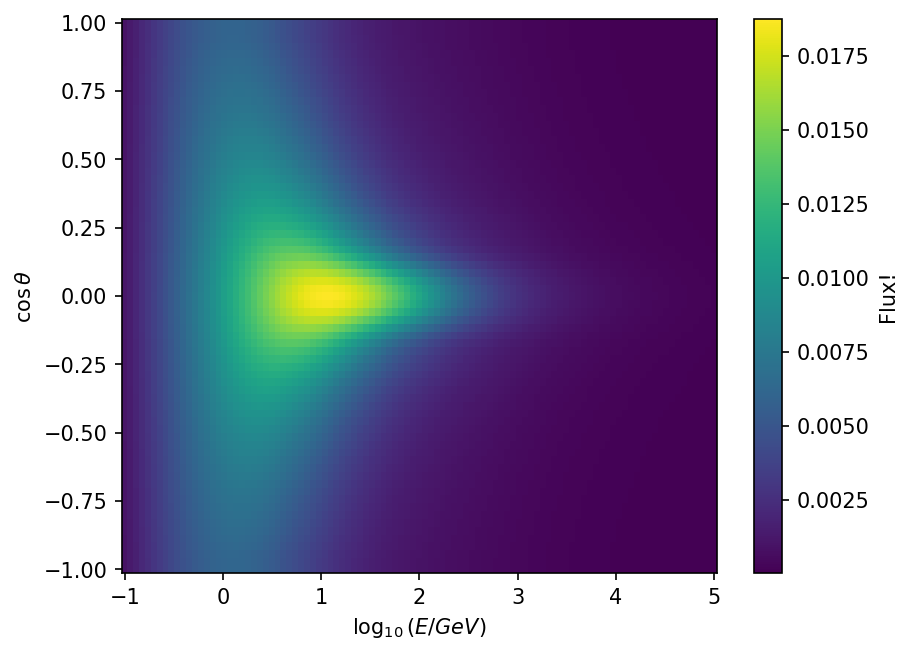

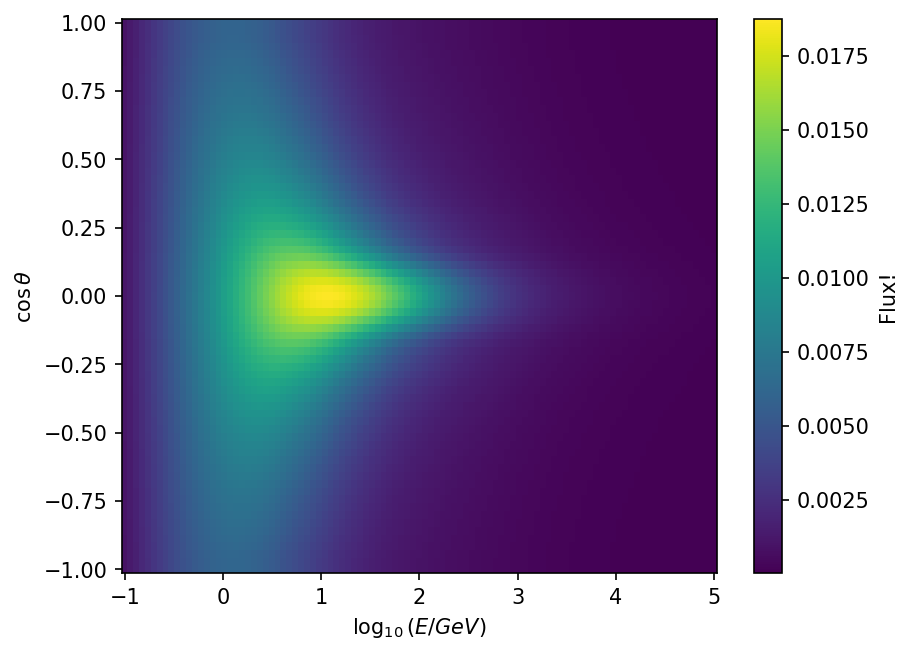

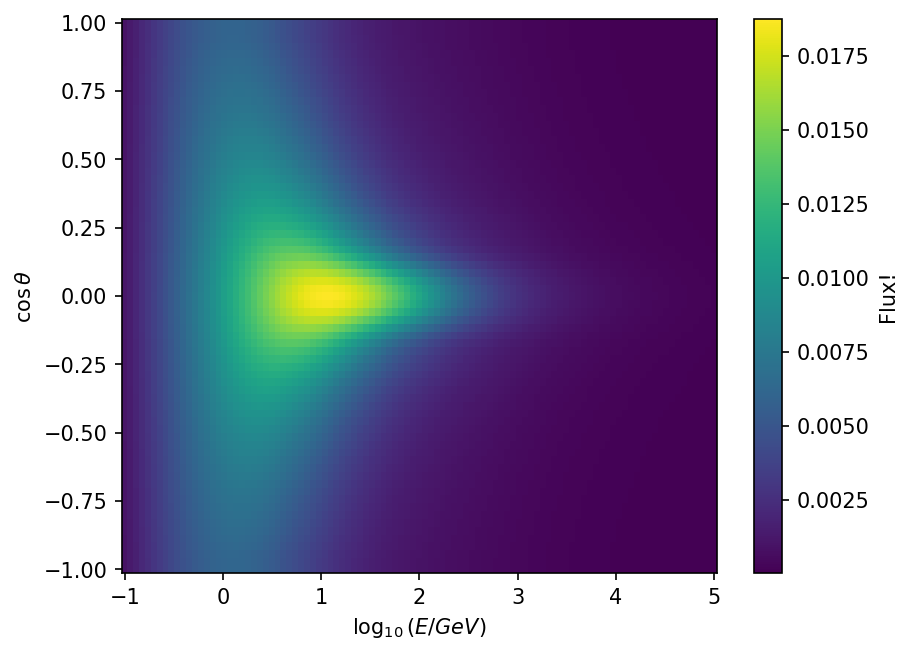

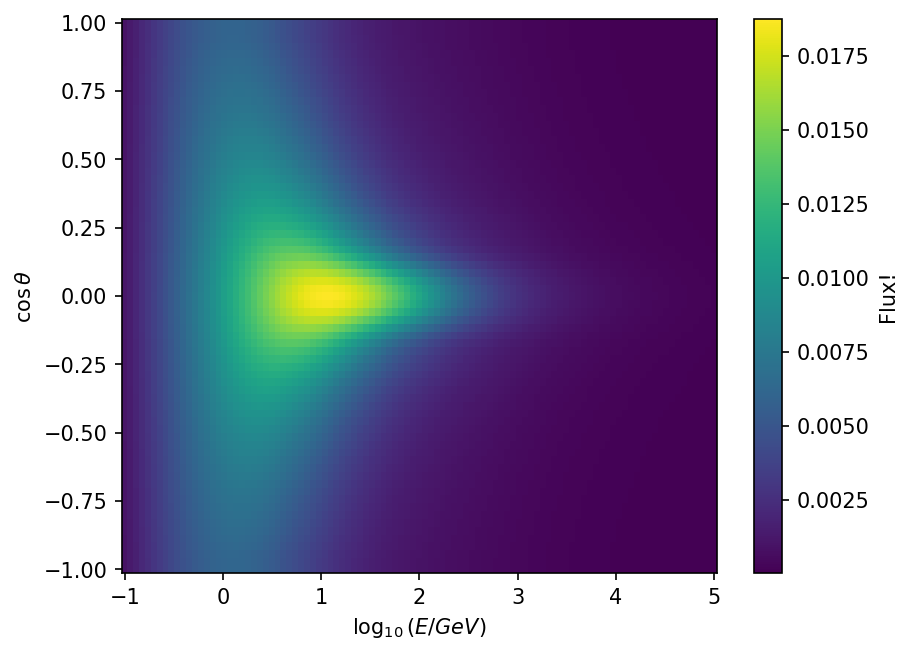

In [34]:
# Loop to plot all the particle fluxes

myegrid = np.linspace(-1,5,101)
myctheta = np.linspace(-1,1, 71)
particles = ['numu','antinumu','nue','antinue']
for onep in particles:
    mypoints = np.zeros([len(myegrid), len(myctheta)])
    for ie in range(myegrid.size):
        for it in range(myctheta.size):
            mypoints = fluxes[onep]['spl3'](myegrid, myctheta)
    plt.figure()
    plt.pcolor(myegrid, myctheta, mypoints.T)
    plt.colorbar(label='Flux!')
    plt.xlabel(r'$\log_{10}(E/GeV)$')
    plt.ylabel(r'$\cos{\theta}$')
